# Extracting Time-Series

- This project shows how one can extract a time series using Earth Engine.
- Given a set of points or polygons, we will extract the NDVI values over a long time-period.

## Data

We will be using MODIS (Moderate Resolution Imaging Spectroradiometer).

### MODIS

- MODIS is a sensor onboard 2 different satellites: Aqua and Terra.
- Temporal resolution: twice daily.
- Spectral resolution: 36 Bands from 400 nm to 14400n nm.
- Spatial resolution: 250m, 500m, 1000m. 

### MODIS Products

MODIS products are available in the following categories:
- Atmospheric products (Aerosols, ..)
- Land products (surface reflectance, Vegetation index, Active fires, ET, ..)
- Cryosphere products (snow cover, ...)
- Ocean products (Sea Surface Temperature, Chlorophyll-A Concentration, etc.)

MODIS data is produced as daily scenes and dervied products (8-day, 16-day, monthly, yearly composites).

We will be using the Terra Vegetation indices 16 day global 250m.

### MODIS Vegetation indices

MOD13 products provide long time series of ready-to-use vegetation indices:
- NDVI: used for low-vegetated areas.
- EVI: adjusts for atmospheric and soil influences, useful for densely vegetated areas. 

The product is derived from 8-day composites.

The product is available at 250m, 500m, 1km resolutions and can be acquired in 16-day and monthly intervals.

For this project, we will use MOD13Q1 product with 250m spatial resolution and 16-day temporal resolution.

## Extracting Time-Series

We want to extract NDVI values at many locations from many images over time.

`ReduceRegion()` function can extract NDVI value form a single MODIS NDVI image for a given geometry.

`ReduceRegions()` can do the same for a feature collection. 

We can `map()` a function of MODIS NDVI collection which uses the `reduceRegions()` function on each image.

In [13]:
%load_ext autoreload
%autoreload 2
%pdb on
%config InlineBackend.figure_format ='retina'
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned ON


In [14]:
import ee
import geemap
ee.Initialize()
m = geemap.Map()
m

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

We will visualize how the average greeness has changed in Moroccan cities over 20 years (from 2000 to 2020):

In [38]:
admins = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
morocco = admins.filter(ee.Filter.eq("ADM0_CODE", 169))
morocco = morocco.filter(ee.Filter.gt("Shape_Area", 0.24))
m.addLayer(morocco, {}, "Morocco")

We get NDVI:

In [39]:
imgs = ee.ImageCollection('MODIS/006/MOD13Q1').select("NDVI")

vis = {
  "min": 0.0,
  "max": 8000.0,
  "palette": [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
}

m.addLayer(imgs.first().clip(morocco), vis, "NDVI sample")

We want to reduce the images into a time-series:

In [40]:
results = ee.FeatureCollection(imgs.map(lambda img: img.reduceRegions(morocco, 
                                                                      ee.Reducer.mean(), 
                                                                      scale=1000))).flatten()
geemap.ee_to_csv(results, "data/time-series.csv")

Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/end-to-end-gee/data/time-series.csv


In [69]:
ndvis = pd.read_csv("data/time-series.csv")
ndvis = ndvis[["system:index", "mean", "ADM2_NAME"]]
ndvis = ndvis.rename(columns={"system:index": "date", "mean": "ndvi", "ADM2_NAME": "city"})
ndvis["date"] = ndvis["date"].apply(lambda d: "-".join(d.split("_")[:-1]))
ndvis["date"] = pd.to_datetime(ndvis["date"], format="%Y-%m-%d")

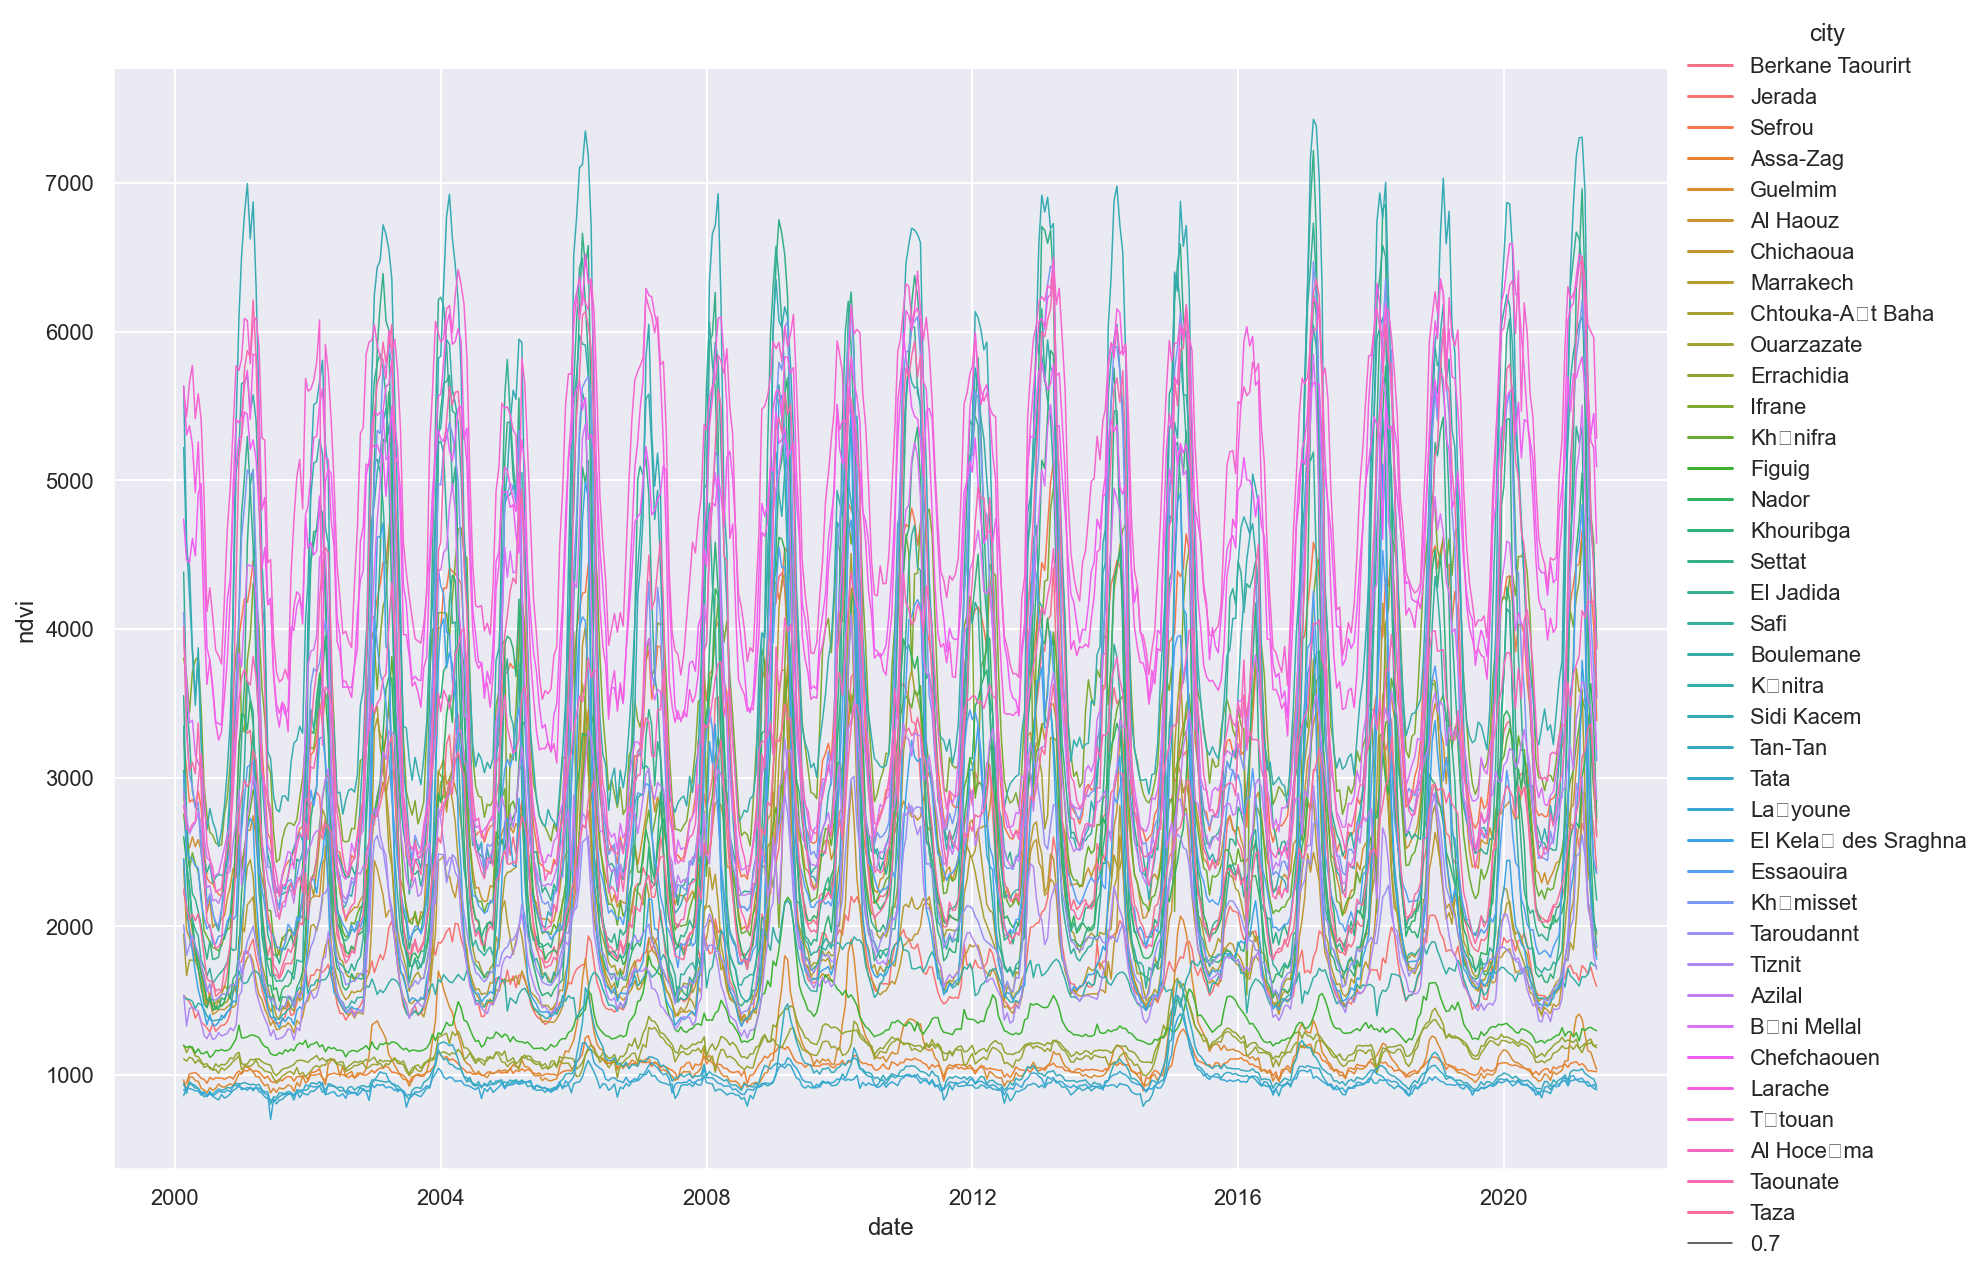

In [84]:
_ = sns.relplot(x="date", y="ndvi", hue="city",
                estimator=None, size=0.7, kind="line", 
                data=ndvis, height=8.27, aspect=11.7/8.27)

In [ ]:
geemap.ee_search()

---